In [21]:
import pickle
import os

FOLDER = os.getcwd() + "/3_closer"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from utils import *
from Dataloader import *
from PSFNet import *

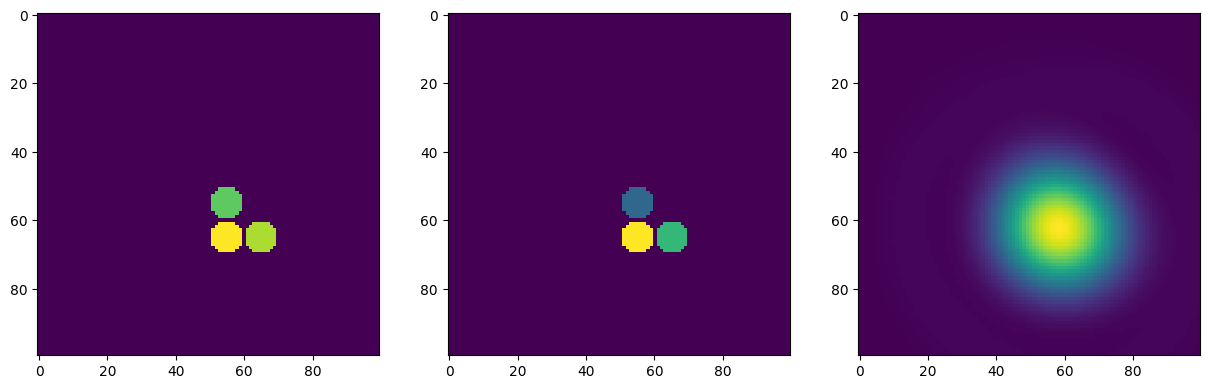

In [23]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
maskSize = EuclideanDistance((0,0),mask.shape)
sourcePts = GetSourcePts(mask,FOLDER)

#Define dataset and dataloader
dataset = Dataloader(out, mask, adjPts=30, randomPts=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

#Define model
model = PSFNet(len(sourcePts),1,dataset.intensityMatrix.data.flatten())

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1, momentum=0)


In [26]:
#Training loop

timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"
oldOut = out.copy()

TrainingLoop(model,dataloader,criterion,optimizer,epochs=400)
oldOut = InverseMatrix(oldOut,mask,sourcePts,model,learningRate=0.5,randomPts=0,adjPts=0)
oldOut = oldOut/max(oldOut.flatten())

print('Finished Training')


Epoch:  1  Loss:  912.5276340842247
Epoch:  21  Loss:  71.54911763221025
Epoch:  41  Loss:  46.184973903000355
Epoch:  61  Loss:  36.0747077614069
Epoch:  81  Loss:  30.57338733971119
Epoch:  101  Loss:  27.11279821395874
Epoch:  121  Loss:  24.732516687363386
Epoch:  141  Loss:  23.020513923838735
Epoch:  161  Loss:  21.724016919732094
Epoch:  181  Loss:  20.716044932603836
Epoch:  201  Loss:  19.916741222143173
Epoch:  221  Loss:  19.255306316539645
Epoch:  241  Loss:  18.722526289522648
Epoch:  261  Loss:  18.27160793542862
Epoch:  281  Loss:  17.89518972299993
Epoch:  301  Loss:  17.56873305886984
Epoch:  321  Loss:  17.29398843832314
Epoch:  341  Loss:  17.051442205905914
Epoch:  361  Loss:  16.84061085432768
Epoch:  381  Loss:  16.666642853990197
Epoch:  400  Loss:  16.511169396340847
[0.3333333333333333, 1.0, 0.6666666666666666]
[[0.93861241]
 [0.87777069]
 [1.        ]]
Finished Training


In [27]:
print(model.polynomial_weights.weight.data)
print(model.polynomial_weights.bias.data)

tensor([[-222.4524]])


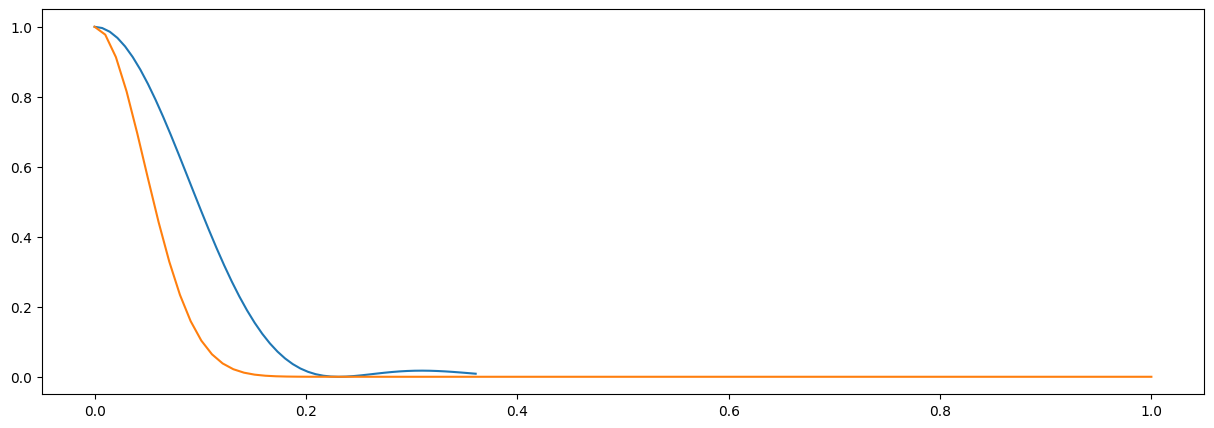

In [28]:
#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
plt.plot(new_psf_x,new_psf_y)
plt.show()


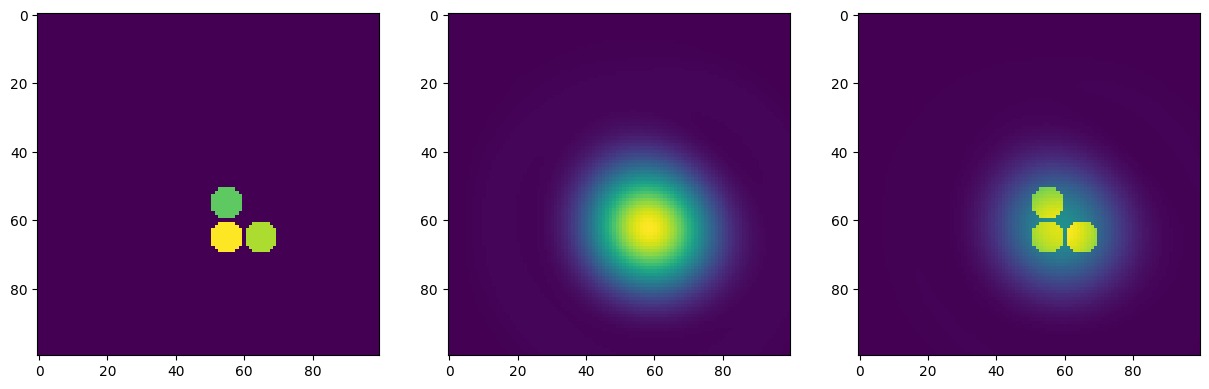

In [29]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(out)
axarr[2].imshow(oldOut)
plt.show()


array([[1.        , 0.23848175],
       [0.23848175, 1.        ]])

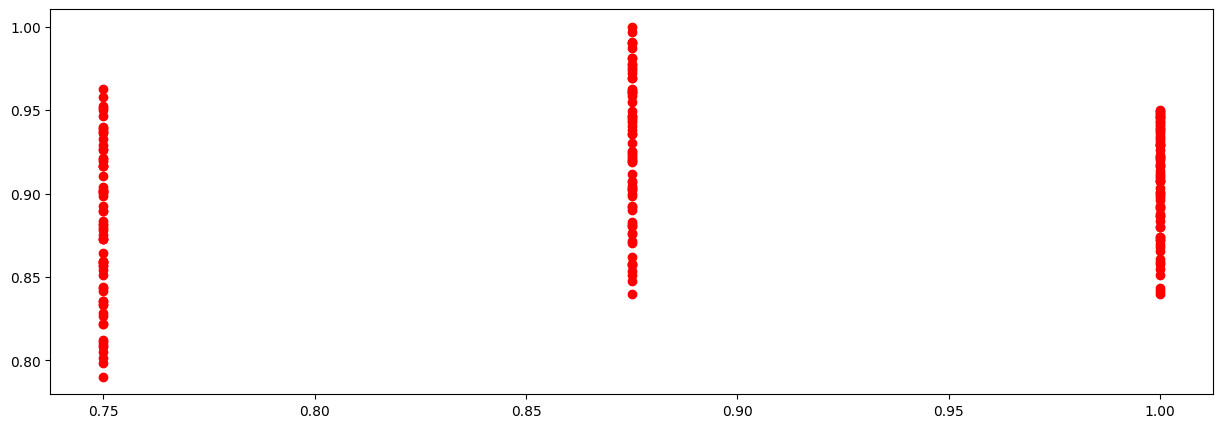

In [30]:
original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(oldOut[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)